In [2]:
# import...
import numpy as np
import os
import matplotlib.pyplot as plt
import xarray as xr
import warnings
import sys

os.chdir(  "/Users/etmu9498/research/code/scripts-winter2023/")
import helper_fns_winter2023
sys.path.append(  "/Users/etmu9498/research/code/scripts-winter2023/cloud-top-height-stats")
import eyewall_metadata
import find_cloud_tops

In [3]:
# make eye cloud height distributions for the four tc categories! see how they compare.
# this code is taken from "scripts-winter2023/cloud-top-height-stats/find_cloud_top_stats"
def find_intensity_stats( tc='all', binwidth=25, smoothwidth=25, eye_limits='default'):
    # empty lists that will hold all the height datasets for each intensity category
    td_heights, td_cases = [], 0
    ts_heights, ts_cases = [], 0
    wh_heights, wh_cases = [], 0
    sh_heights, sh_cases = [], 0
    crl_root_path = "/Users/etmu9498/research/data/crl-all-data-processed/"


    # use a helper fn to get the relevant years and files
    yearlist, filelist = helper_fns_winter2023.get_crl_datasets( tc=tc)

    # print out the number of files to be used
    filecount = 0
    for yeari in range( len( filelist)):
        # count all the names in this year, and add to the count
        filecount += len( filelist[ yeari])
    print("Number of data files to be used in analysis: " + str( filecount))

    # load eyewall limits from helper function
    metadata = eyewall_metadata.all_metadata( eye_limits=eye_limits)

    # do this for all the datasets! years and filenames
    for yeari, yearval in enumerate( yearlist):
        print( "Year: " + yearval)
        for filei, fileval in enumerate( filelist[ yeari]):
            print( "File: " + fileval)

            # grab the limits for this case
            # simplified filename
            date = fileval[7:11]
            # check if this date exists... if not, give it some empty eyewall limits!
            # also account for fred am and pm cases!!
            if date == '0812':
                if fileval[11:13] == "H1":
                    eyewall_limits = metadata[ yearval]['eyewall_limits'][ '0812am']
                elif fileval[11:13] == "H2":
                    eyewall_limits = metadata[ yearval]['eyewall_limits'][ '0812pm']
            elif date in metadata[ yearval]['eyewall_limits'].keys():
                eyewall_limits = metadata[ yearval]['eyewall_limits'][ date]
            else:
                eyewall_limits = [ ()]

            # make sure intensity metadata are inputed for this year!
            if len( metadata[yearval]['intensity'].keys() ) > 0:
                if date == '0812':
                    if fileval[11:13] == "H1":
                        intensity = metadata[ yearval]['intensity'][ '0812am']
                    elif fileval[11:13] == "H2":
                        intensity = metadata[ yearval]['intensity'][ '0812pm']
                elif date in metadata[ yearval]['intensity'].keys():
                    intensity = metadata[yearval]['intensity'][date]
                else:
                    print( metadata[ yearval]['intensity'].keys())
                    intensity = 0
            else:
                intensity = 0

            # do this for each of the eyewall limit pairs! Can have multiple eyes per crl dataset
            for eyei, eyeval in enumerate( eyewall_limits):
                # load crl data
                os.chdir( crl_root_path + yearval)
                crl_data = xr.open_dataset( fileval)

                if len( eyeval) > 0:

                    # find the corresponding indices to the time limits
                    ind0 = np.argmin( np.abs(crl_data.time.values - eyeval[0] ))
                    ind1 = np.argmin( np.abs(crl_data.time.values - eyeval[1] ))

                    # clip relevant fields down to the eyewall limits
                    H = crl_data.height
                    power = crl_data.P_ch1[ ind0 : ind1, :]
                    axis = crl_data.time[ ind0 : ind1]
                    p3_height = crl_data.p3_height[ ind0 : ind1]

                    #print( "h: " + str( len( H)))
                    #print( "power: " + str( np.shape( power)))
                    #print( 't: ' + str( len( axis)))

                    # find cloud top heights for values within the specified eye distance range
                    if yearval == '2021':
                        cutoff = -30
                    elif yearval == '2022':
                        cutoff = -40
                    heights, time = find_cloud_tops.find_cloud_heights( H, power, axis, p3_height, cutoff_power = cutoff)

                    # save height values from this run
                    if date == '0812':
                        if fileval[11:13] == "H1":
                            category = metadata[yearval]['category']['0812am'] # tc intensity category
                        elif fileval[11:13] == "H2":
                            category = metadata[yearval]['category']['0812pm'] # tc intensity category
                    elif date in metadata[ yearval]['eyewall_limits'].keys():
                        category = metadata[yearval]['category'][date]

                    # figure out where to put the height data depending on the tc intensity!
                    if category == 'td':
                        td_heights += np.ndarray.tolist( heights)
                        # print( 'td')
                        td_cases += 1
                    elif category == 'ts':
                        ts_heights += np.ndarray.tolist( heights)
                        ts_cases += 1
                    elif category == 'wh':
                        wh_heights += np.ndarray.tolist( heights)
                        wh_cases += 1
                    elif category == 'sh':
                        sh_heights += np.ndarray.tolist( heights)
                        sh_cases += 1

    data = [ td_heights, ts_heights, wh_heights, sh_heights]
    cases = [ td_cases, ts_cases, wh_cases, sh_cases]
    tccat = ['td', 'ts', 'wh', 'sh']
    for datai, dataval in enumerate( data):
        test_ht = np.array( dataval)
        test_ht = test_ht[ np.where( test_ht > 50)[0] ]

        print( "\n" + tccat[ datai])
        print( "cases: " + str( cases[ datai]))
        print("orig number of data points: " + str( len( dataval)))
        print("non zero number of data points: " + str( len( test_ht)))
        print("orig mean ht = " + str( np.round( np.nanmean( dataval), 3)))
        print("non zero mean ht = " + str( np.round( np.nanmean( test_ht), 3)))
        if len( dataval) > 0:
            print("clear air % = " + str( 100 *( 1 - np.round( len( test_ht ) / len( dataval), 3)) ))
        else:
            print("No cases for this intensity and year combination.")

    # make a nice figure for these tc intensities!
    intensity_bins( tc, td_heights, ts_heights, wh_heights, sh_heights, binwidth, smoothwidth)


In [4]:
def intensity_bins( year, td_heights, ts_heights, wh_heights, sh_heights, binwidth=25, smoothwidth=25, lw=2):
    # create histograms for every TC intensity
    # put things in lists for easier looping
    fig_title = [ 'tropical-depressions', 'tropical-storms', 'weak-hurricanes', 'strong-hurricanes']
    # nicely formatted titles for plots, as opposed to saving
    fig_title_nice = [ 'Tropical Depressions', 'Tropical Storms', 'Weak Hurricanes', 'Strong Hurricanes']
    colors = [ 'b', 'k', 'y', 'g']
    heights = [ td_heights, ts_heights, wh_heights, sh_heights]
    savedir = "/Users/etmu9498/research-private/eye-cloud-paper/fig4-intensity"

    # make figure before loop
    fig, a0 = plt.subplots(1, 1, figsize=( 7, 7) )
    smallfont=16
    mediumfont=16
    largefont=20
    # set the figure background (not plot background!) to transparent!!
    # fig.patch.set_facecolor('blue')
    # fig.patch.set_alpha(0)

    # create a histogram
    plt.sca( a0)
    # loop through each case
    for i in range( 4):
        height = np.array( heights[ i])
        # remove 0 km heights from figure!
        plot_height = height[ np.where( height > 50)[0] ]
        height_bin=np.arange(0, 4510, binwidth)

        # calculate mean height variation within the bin range
        mean_height=[]
        mean_height_count=[]
        mean_height_prob = []

        # do this for every height level determined by the manually inputed bin width
        for newi in height_bin:

            # find the points that fall within this height bin for this step
            res=np.where(np.logical_and( plot_height >= newi - binwidth / 2., plot_height <= newi + binwidth / 2. ))

            # print( plot_height[ res])

            mean_height.append( np.mean( plot_height[ res]))
            mean_height_count.append( len( res[0]))
            # use height, not plot_height, to include heights below 50m in caclulations
            # this line accounts for clear air fraction when scaling the curves!
            if len( height) > 0:
                mean_height_prob.append( len( res[0] ) / len( height))
            else:
                # this should only happen if there's no data at this height bin... unlikely,
                # unless there are no cases at this cat
                if newi == 0:
                    print( "Divide by 0 attempted :/")
                mean_height_prob.append( len( res[0] ) / .00001 )


        # smooth data before plotting to eliminate noise
        box_pts = smoothwidth
        box = np.ones(box_pts)/box_pts
        prob_smooth = np.convolve( mean_height_prob, box, mode='same')

        # remove 0% probability lines (mostly at high alts) from histogram plots!
        prob_smooth_trim = prob_smooth[ np.where( prob_smooth > 0.00001)[0]]
        height_trim = height_bin[ np.where( prob_smooth > 0.00001)[0]]

        # add the probability plot to the total figure! will add nice touches and save later
        a0.plot( prob_smooth_trim * 100, height_trim, color=colors[i], label=fig_title_nice[i], linewidth=lw)


        # use the highest smoothed value to effectively scale the x axis!!
        max_prob = np.nanmax( prob_smooth)
        # print( 'max prob: ' + str( max_prob))


        # make and save separate plots for each intensity! in the same output folder
        fig1, a1 = plt.subplots(1, 1, figsize=( 7, 7) )
        # set the figure background (not plot background!) to transparent!!
        fig1.patch.set_facecolor('blue')
        fig1.patch.set_alpha(0)
        plt.sca( a1)
        a1.plot( np.array( mean_height_prob) * 100, height_bin, color=colors[i], label='Raw Data: Bins = ' + str( binwidth) + " m", linewidth=lw/2, alpha=.7)
        a1.plot( prob_smooth * 100, height_bin, color=colors[i], label='Smoothed Data', linewidth=lw)

        # a1.set_xlabel('Cloud Height Probability (Sums to 1)', fontsize=mediumfont)
        a1.set_xlabel('Cloud Height Probability (%)', fontsize=mediumfont)

        # sns.set_theme(style="white", palette=None)
        a1.set_ylabel( 'Height from Surface (Km)', fontsize=mediumfont)
        # a1.set_ylim( [-.2, 4.5])
        a1.set_ylim( [-200, 4500])

        # a0.set_xlim( [ 0, 1.05])
        # a1.set_xlim( [ 0, .02])
        a1.set_xlim( [ 0, max_prob * 2 * 100])


        a1.grid(False)
        a1.set_title( "Cloud Height Distributions for " + fig_title_nice[i], fontsize=largefont)
        a1.tick_params(axis='both', which='major', labelsize=smallfont)
        a1.legend(fontsize=smallfont, loc="upper right")

        os.chdir( savedir)
        plt.savefig( str( int( binwidth)) + "m-" + year + "-" + fig_title[i] + ".png", bbox_inches='tight', dpi=500, transparent=False )
        plt.sca( a0)

    # save the total figure!
    a0.set_ylabel( 'Height from Surface (Km)', fontsize=mediumfont)
    a0.set_xlabel('Cloud Height Probability (%)', fontsize=mediumfont)
    a0.set_ylim( [-200, 4600])
    a0.grid(False)

    a0.set_title( year + " Cloud Height Distributions", fontsize=largefont)
    a0.tick_params(axis='both', which='major', labelsize=smallfont)
    plt.legend(fontsize=smallfont, loc="upper right")
    plt.savefig( str( int( binwidth)) + "m-" + year + "-all-dists.png", bbox_inches='tight', dpi=500, transparent=False )

Number of data files to be used in analysis: 18
Year: 2022
File: P3_20220830H1_processed.nc
File: P3_20220831H1_processed.nc
File: P3_20220901H1_processed.nc
File: P3_20220903H1_processed.nc
File: P3_20220904H1_processed.nc
File: P3_20220905H1_processed.nc
File: P3_20220906H1_processed.nc
File: P3_20220908H1_processed.nc
File: P3_20220916H1_processed.nc
File: P3_20220917H1_processed.nc
File: P3_20220918H1_processed.nc
File: P3_20220920H1_processed.nc
File: P3_20220924H1_processed.nc
File: P3_20220925H1_processed.nc
File: P3_20220926H1_processed.nc
File: P3_20220927H1_processed.nc
File: P3_20221007H1_processed.nc
File: P3_20221008H1_processed.nc

td
cases: 3
orig number of data points: 230
non zero number of data points: 154
orig mean ht = 723.516
non zero mean ht = 1078.568
clear air % = 32.99999999999999

ts
cases: 30
orig number of data points: 2227
non zero number of data points: 1906
orig mean ht = 1451.162
non zero mean ht = 1694.854
clear air % = 14.400000000000002

wh
cases: 10


C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


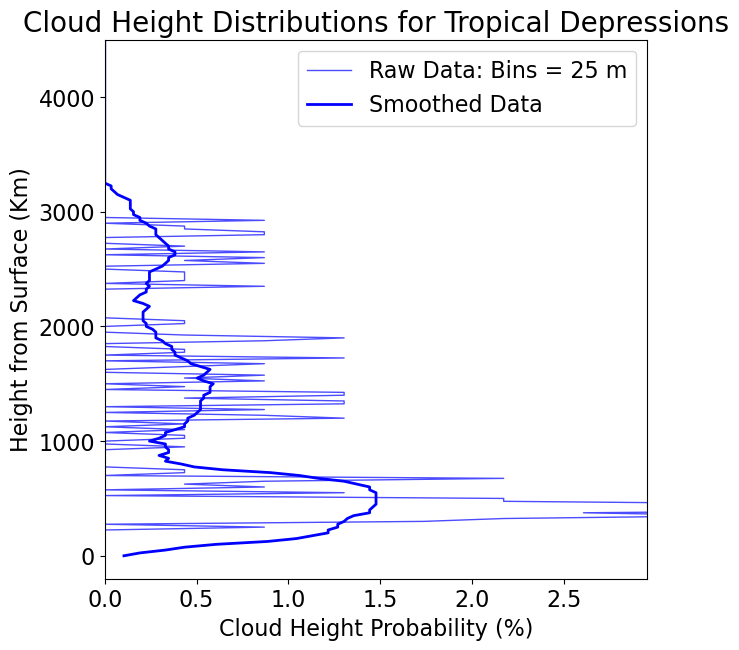

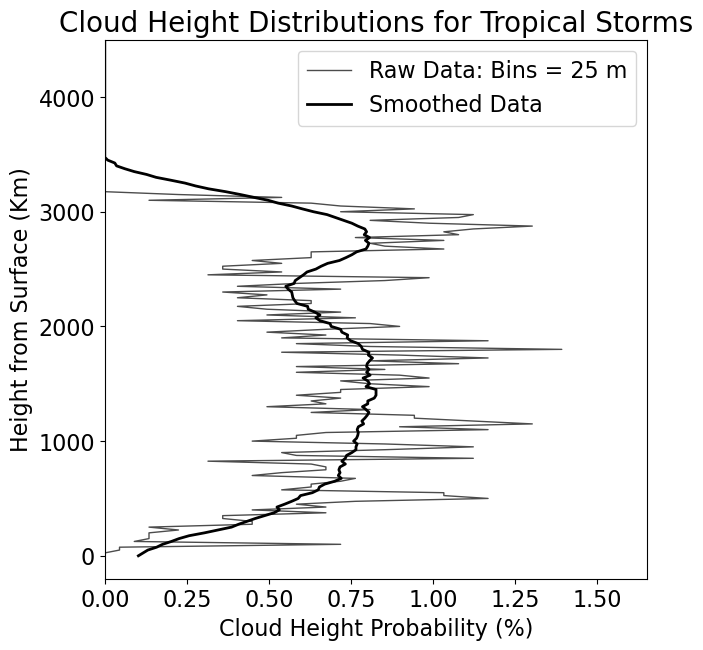

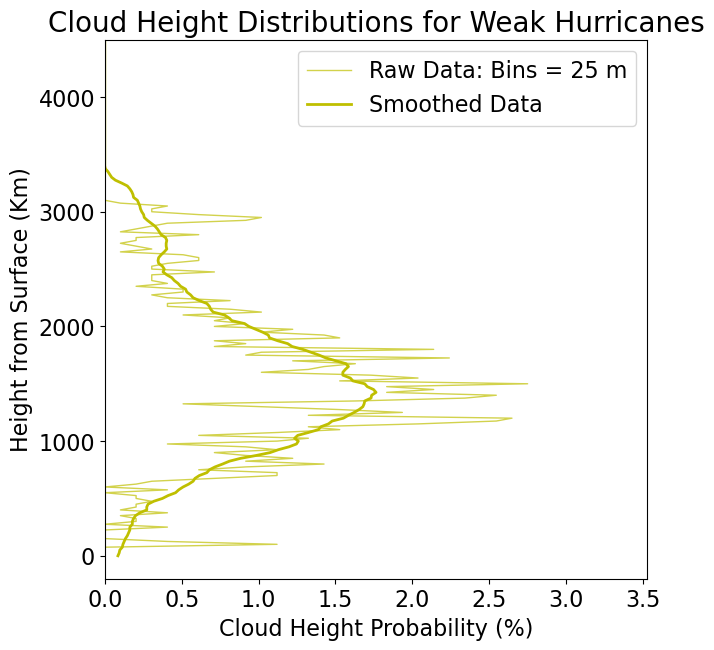

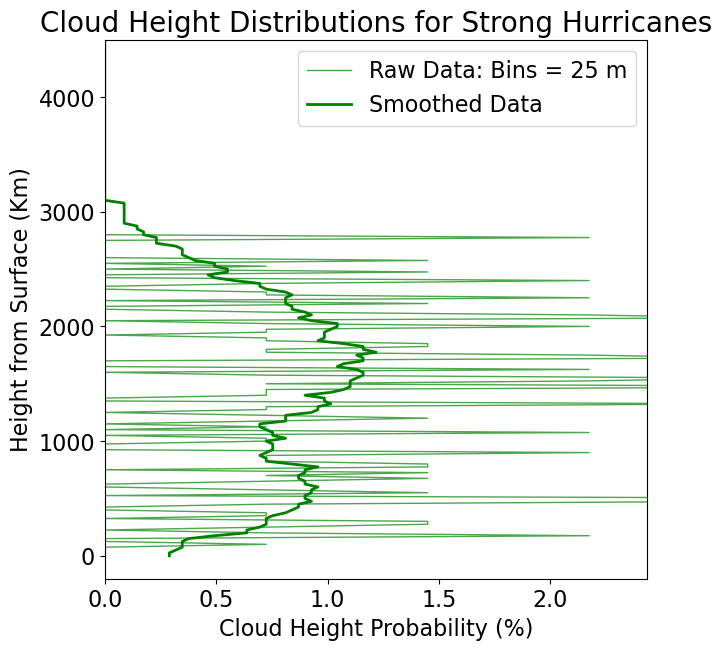

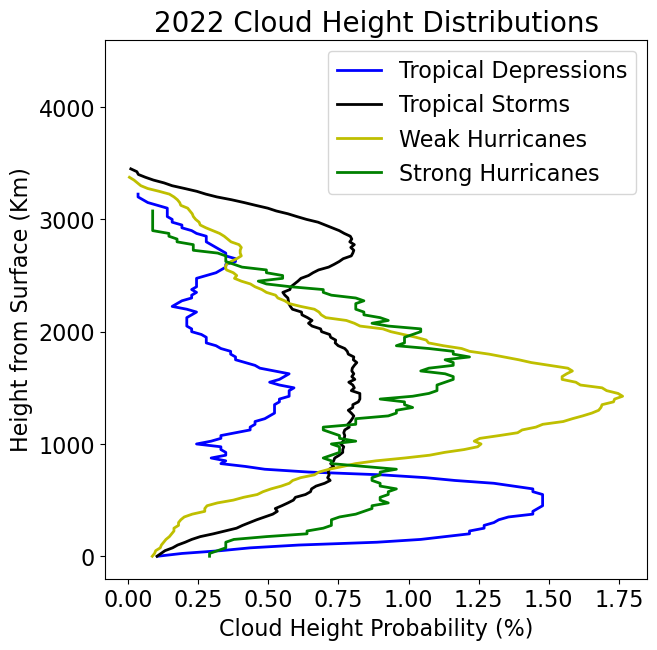

In [6]:
# find_intensity_stats(tc='all', binwidth=150, smoothwidth=1)
find_intensity_stats(tc='2022', binwidth=25, smoothwidth=25)